# Classification

## Objectif

Dans cette partie "classification", on cherche à prédire si les prix de l'électricité au Canada va augmenter (UP) ou diminuer (DOWN) comparé aux dernières 24h. Il s'agit d'un problème de classification binaire en se basant sur des données numériques comme l'offre et la demande. L'objectif est donc de trouver une séparation des données qui se rapproche le plus possible de la rélaité.

## Importation des dépendances

Nous importons les dépendances python en début de fichier pour faciliter leur utilisation par la suite.

In [54]:
import pandas as pd
from pandas.plotting import scatter_matrix
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import datetime

## Chargement des données

Nos données d'entrainnement sont situées dans des fichiers CSV

Dans un premier temps, il faut charger ces données CSV avec Pandas

In [55]:
df_train = pd.read_csv("train.csv")

## Parcours des données

In [16]:
df_train.head()

,id,date,hour,bc_price,bc_demand,ab_price,ab_demand,transfer,bc_price_evo
0,0,0.452060,1.000000,0.074096,0.578846,0.005029,0.494821,0.489912,UP
1,1,0.455555,0.574468,0.033025,0.349003,0.001554,0.264889,0.829386,DOWN
2,2,0.027521,0.617021,0.098325,0.533918,0.003467,0.422915,0.414912,UP
3,3,0.455732,0.936170,0.041822,0.588515,0.002860,0.448731,0.525000,UP
4,4,0.000044,0.255319,0.051489,0.302440,0.003467,0.422915,0.414912,UP


In [12]:
print(df_train.columns)
print(df_train.dtypes)

Index(['id', 'date', 'hour', 'bc_price', 'bc_demand', 'ab_price', 'ab_demand',
       'transfer', 'bc_price_evo'],
      dtype='object')
id                int64
date            float64
hour            float64
bc_price        float64
bc_demand       float64
ab_price        float64
ab_demand       float64
transfer        float64
bc_price_evo     object
dtype: object


In [13]:
print(df_train.isnull().sum())
df_train.shape

id              0
date            0
hour            0
bc_price        0
bc_demand       0
ab_price        0
ab_demand       0
transfer        0
bc_price_evo    0
dtype: int64


(28855, 9)

Le dataset est assez propre. Pas de valeurs nulles ou de valeurs manquantes. 

9 colonnes et 28855 lignes. Que des variables numériques

## Preprocessing
On supprime la colonne id qui n'est pas pertinente pour notre modèle

On verra également par la suite que la colonne "transfer" n'est pas pertinente pour le modèle.

On sépare la varaible cible des autres variables 

In [56]:
target_name = "bc_price_evo"
target, data = df_train[target_name] , df_train.drop(columns=[target_name,"id","transfer"])   #On sépare la colonne target des autres colonnes

## Quelques plots 
Pour évaluer les liens possibles entre les variables

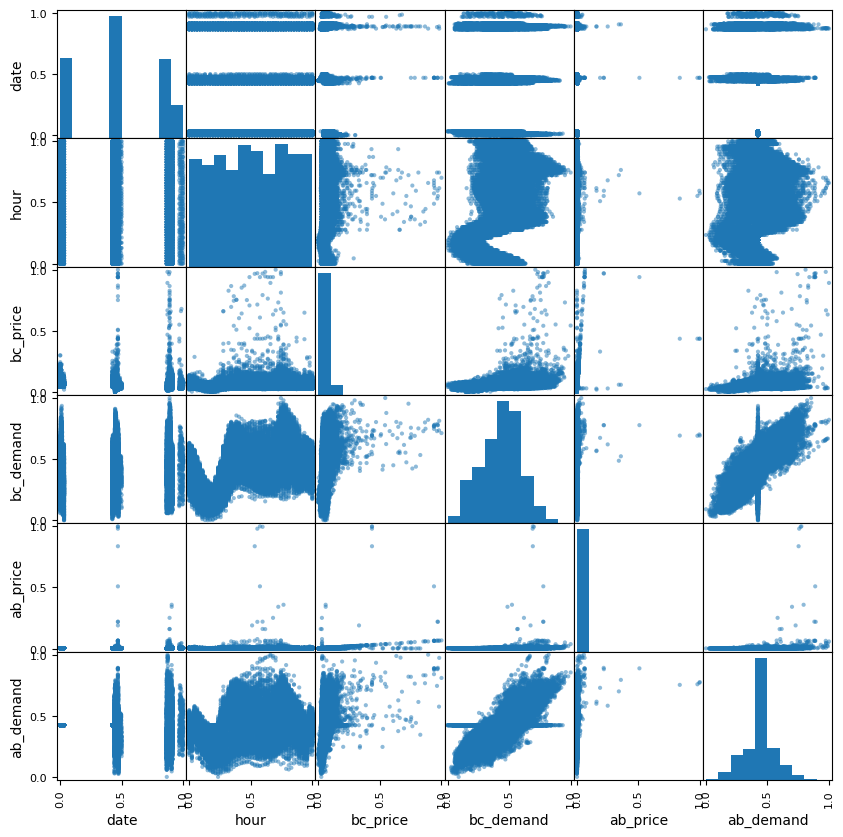

In [8]:
scatter_matrix(data,figsize=(10,10))
plt.show()

### Matrice de Corrélation

Cette matrice va permettre de savoir s'il y'a une corrélation forte entre les variables dans le dataset

Matrice de corrélation :
               date      hour  bc_price  bc_demand  ab_price  ab_demand
date       1.000000 -0.003111 -0.137605   0.069534  0.007974   0.075119
hour      -0.003111  1.000000  0.100880   0.422406  0.020527   0.179115
bc_price  -0.137605  0.100880  1.000000   0.307547  0.289124   0.305037
bc_demand  0.069534  0.422406  0.307547   1.000000  0.083369   0.668936
ab_price   0.007974  0.020527  0.289124   0.083369  1.000000   0.126375
ab_demand  0.075119  0.179115  0.305037   0.668936  0.126375   1.000000


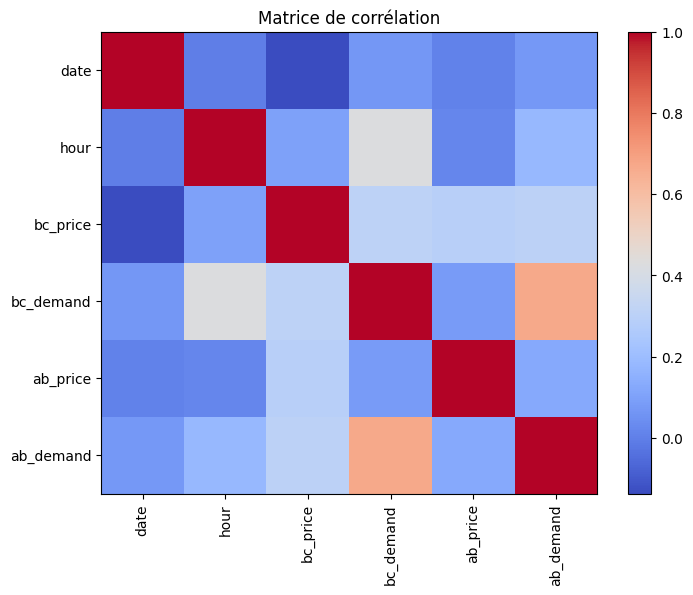

In [15]:
# Calculer la matrice de corrélation
correlation_matrix = data.corr()

# Afficher la matrice de corrélation
print("Matrice de corrélation :")
print(correlation_matrix)

# Afficher la corrélation sous forme de heatmap
plt.figure(figsize=(8, 6))
plt.title('Matrice de corrélation')
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none', aspect='auto')
plt.colorbar()
plt.xticks(range(len(correlation_matrix)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix)), correlation_matrix.columns)
plt.show()

Il y'a une correlation assez importante entre les variables "bc_demand" et "ab_demand". Dans un premier temps, on a fusionné les deux variables de deux manières differentes :
- Multiplication : demand = bc_demand * ab_demand
- Avec PCA :  

On a voulu fusionner ces deux variables car on a pensé que des variables correlées pouvaient influencé les performances de notre modèle. Mais après quelques recherches et tests, des modèles comme "Random Forest" sont plus performants avec les deux informations.

Les codes de nos deux tentatives de fusion ont été mis en commentaire.

In [148]:
#data["demand"] = data["ab_demand"] * data["bc_demand"]
#data = data.drop(columns=["ab_demand","bc_demand"])

In [ ]:
#pca = PCA(n_components=1)
#X = data[["ab_demand", "bc_demand"]]
#data["demand"] = pca.fit_transform(X)
#data = data.drop(columns=["ab_demand","bc_demand"])

Nous avons également tenter de fusionner les variables "date" et "heure" pour obtenir le temps exact de la prise des données.
Cette tentative s'est aussi avérée inefficace (a diminué les performances du modèle) car en faisant cela, nous perdons des informations importantes.

Par exemple, il peut avoir une demande d'électricité plus importante en soirée que en journée. Donc l'information de l'heure est très importante et doit etre traité séparement des dates.

Et les dates aussi sont aussi très importantes car par exemple, il peut avoir une plus grande demande d'électricité en Hiver qu'au printemps par exemple. Raison de plus pour ne pas fusionner les dates et les heures, pour que notre modèle soit robuste.

In [79]:
#date1 = datetime.strptime("15/05/2015", "%d/%m/%Y")
#date2 = datetime.strptime("13/12/2017", "%d/%m/%Y")

#difference = date2 - date1
#nombre_jours = difference.days

#data["date"] = data["date"] + (data["hour"]*23.5)/(24*nombre_jours)   #Les heures sont entre 0 et 47 donc entre 0 23.5
#data = data.drop(columns=["hour"])

### Utilisons Scikit-learn pour diviser nos données

In [57]:
x_train, x_val, y_train, y_val = train_test_split(data, target, test_size=0.2, random_state=1)
x_train = x_train.reset_index().drop('index', axis=1)
x_val = x_val.reset_index().drop('index', axis=1)

In [58]:
x_train.head()

,date,hour,bc_price,bc_demand,ab_price,ab_demand
0,0.456484,0.042553,0.032725,0.304374,0.002210,0.475142
1,0.872307,0.787234,0.035547,0.417138,0.002075,0.234076
2,0.912349,0.404255,0.076528,0.543588,0.005224,0.608234
3,0.434361,0.127660,0.046625,0.112615,0.003467,0.422915
4,0.452192,0.021277,0.033265,0.353317,0.002289,0.323925


# Construction des modèles
Faisons d'abord les fonctions de prédictions, Cross Validation et submit.

### Fonction pour avoir le score de prédiction sur l'ensemble d'entrainement
Ce score doit etre très proche de 1 pour un bon modèle, car le modèle est entrainé sur l'ensemble d'entrainement et donc doit etre en mesure de bien prédire sur ces données

In [25]:
def score_train(model,data,target):
    score = model.score(data,target)
    print(score)

### Fonction pour la Cross Validation (validation croisée)

In [60]:
def validate(model,data,target):
    scores = cross_validate(
        model, data, target, cv=5, n_jobs=2, return_estimator=True      #Cinq validations croisées
    )
    cv_test_scores = scores['test_score']
    print(f"Les scores par la validation croisée {cv_test_scores}")

### Fonction pour l'évaluation de notre modèle  et création du fichier pour le submit sur Kaggle

In [59]:
def submit(model) :
    data_test = pd.read_csv("test.csv")
    data_test_processed = data_test.drop(columns=["id","transfer"])
    
    predictions = model.predict(data_test_processed)                                       # Faire des prédictions avec le modèle
    result_df = pd.DataFrame({'id': data_test["id"], 'predictions': predictions})          # Créer un DataFrame avec les colonnes "id" et "predictions"
    result_df.to_csv("predictions.csv", index=False)    

## --- Random Forest (91.45%)

Dans cette partie, nous allons implémenter un random forest (en francais foret aléatoire)

In [61]:
forest = RandomForestClassifier(n_estimators = 300, criterion='entropy',max_features=5,max_depth=200)

Entrainnement sur une partie de data_train et évaluation du modèle

In [62]:
forest.fit(x_train,y_train)
forest.score(x_val,y_val)

0.8958586033616358

In [63]:
# Obtenir l'importance des variables
feature_importances = forest.feature_importances_

for i, importance in enumerate(feature_importances):
    print(f"Variable {data.columns[i]} : {importance}")

Variable date : 0.2815753144557357
Variable hour : 0.08796400552565144
Variable bc_price : 0.3531731226926038
Variable bc_demand : 0.14209869880147175
Variable ab_price : 0.07078216475236714
Variable ab_demand : 0.06440669377217027


On voit que les variables les plus importantes pour le modèle sont "bc_price" et "date", ce qui pouvait etre prévisible. En effet, les variations du prix d'électricité au Canada dépendent du prix en lui meme et des saisons par exemple.

Comme dit précedemment, on a essayé de fusionner la [date et l'heure] et [bc_demand et ab_demand]. Cette fusion diminue la précision de notre modèle. Ceci s'explique par le fait que :


Enfin, le poids accordé à la variable "transfer" était de [Variable transfer : 0.05608319914737203]. Ce qui nous a mis la puce à l'oreille. "Est ce que cette varaible est pertinente ?". En relisant la description des données, on l'a enlevé du modèle et on a obtenu un modèle plus robuste.

Validation croisée

In [38]:
validate(forest,data,target)                    #Validation croisée

Les scores par la validation croisée [0.89256628 0.89343268 0.90278981 0.89568532 0.89724484]


Hyper parameter Tuning de Random Forest

Dans cette partie, nous allons réaliser un tuning des hyper paramètres de notre modèle Random Forest.

In [ ]:
param_grid = {
    'n_estimators': [300, 500, 1000, 5000],
    'learning_rate': [0.01, 0.05, 0.1, 0.5],
    'max_depth': [10, 100, 200]
}

In [ ]:
random_cv_forest = RandomizedSearchCV(
    estimator=forest,
    param_distributions=param_grid,
    cv=3,                                           #Trois validations croisées pour déterminer les meilleures hyper paramètres
    n_iter=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=5,
    return_train_score=True,
    random_state=0
)

In [ ]:
random_cv_forest.fit(x_train, y_train)
random_cv_forest.best_params_

Une fois nos meilleurs hyperparamètres obtenus, nous pouvons entrainé notre modèle finale sur tout le jeu de donnnées et avoir les prédictions sur le jeu de test

Entrainnement sur tout le jeu de données

In [ ]:
forest_classifier =  forest.fit(data, target)
submit(forest_classifier)                       #Crée le fichier de soumission pour Kaggle

## --- AdaBoost (Adaptative Boosting) (93.47%) Notre meilleur modèle

In [64]:
ada =  AdaBoostClassifier(estimator =DecisionTreeClassifier(max_depth=8),n_estimators=5000,algorithm="SAMME",learning_rate=0.5,random_state=42)

In [ ]:
ada.fit(x_train,y_train)
ada.score(x_val,y_val)

Validation croisée

In [ ]:
validate(ada,data,target)

Hyper parameter Tuning de AdaBoost

Dans cette partie, nous allons réaliser un tuning des hyper paramètres de notre modèle AdaBoost.

In [65]:
param_grid = {
    'n_estimators': [3000, 5000, 10000],
    'learning_rate': [0.01, 0.05, 0.1, 0.5],
    'base_estimator__max_depth': [8, 12, 16]
}

RandomizedSearchCV a été préféré à GridSearchCV car GridSearchCV teste toutes les combinaisons ce qui prend énormément de temps.

In [ ]:
random_cv_ada = RandomizedSearchCV(
    estimator=ada,
    param_distributions=param_grid,
    cv=3,                                           #Trois validations croisées pour déterminer les meilleures hyper paramètres
    n_iter=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=5,
    return_train_score=True,
    random_state=0
)

In [ ]:
random_cv_ada.fit(x_train, y_train)
random_cv_ada.best_params_

Une fois nos meilleurs hyperparamètres obtenus, nous pouvons entrainé notre modèle finale sur tout le jeu de donnnées et avoir les prédictions sur le jeu de test

Entrainnement sur tout le jeu de données

In [48]:
ada_classifier = ada.fit(data, target)
submit(ada_classifier)

### Pourquoi AdaBoost est meilleur que Random Forest ?

AdaBoost est un algorithme de ...

## --- XGBoosting (Extreme Gradient Boosting)

In [156]:
xgb = XGBClassifier(use_label_encoder = False, eval_metric ='logloss')

1.0


In [ ]:
xgb.fit(x_train,y_train)
xgb.score(x_val,y_val)

In [ ]:
validate(xgb,data,target)   #Validation croisée

Hyper parameter Tuning de XGBoosting

Dans cette partie, nous allons réaliser un tuning des hyper paramètres de notre modèle XGBoosting.

In [ ]:
param_grid = {
    'n_estimators': [3000, 5000, 10000],
    'learning_rate': [0.01, 0.05, 0.1, 0.5],
    'base_estimator__max_depth': [8, 12, 16]
}

In [ ]:
random_cv_xgb = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    cv=3,                                           #Trois validations croisées pour déterminer les meilleures hyper paramètres
    n_iter=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=5,
    return_train_score=True,
    random_state=0
)

In [ ]:
random_cv_xgb.fit(x_train, y_train)
random_cv_xgb.best_params_

Entrainnement sur tout le jeu de données

In [ ]:
xgb_classifier = xgb.fit(data, target)
submit(xgb_classifier)

### K Nearest Neighbors

In [ ]:
k_classifier = KNeighborsClassifier(n_neighbors=10 , weights= "distance").fit(data, target)
score = k_classifier.score(data,target)
print(score)

### Support Vector Machines

Dans cette partie, nous allons implémenter un SVM, avec Kernel Linéaire

Malheuresement, un modèle linéaire n'est pas pertinent pour ce modèle. Les données ne peuvent pas etre séparées par une droite

In [34]:
svm_model_linear = SVC(kernel = 'linear').fit(data, target)
accuracy = svm_model_linear.score(data, target)
print("Précision du test:",accuracy)

Précision du test: 0.7238055613341654


### Bagging Classifier

Dans cette partie, nous allons implémenter un Bagging Classifer

In [ ]:
bagging = BaggingClassifier(estimator=forest_classifier ,n_estimators=4000, max_features=5)
bagging_classifier = bagging.fit(data,target)